In [1]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-23 05:45:11--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  24.1MB/s    in 32s     

2025-01-23 05:45:44 (23.6 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [2]:
!pip install torchinfo

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [28]:
batch_size = 32
learning_rate = 5e-5
num_epochs = 30
weight_decay = 1e-6

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LeViTDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LeViTDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LeViTDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=1e-6)

LeViTDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LeViTDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

# Dataset setup
- NCT-CRC-HE-100K is for training only.
  - we split this into 7:1.5:1.5 ratio for train/val/test.
- CRC-VAL-HE-7K is for validation **after** the training is complete.

- If needed we perform augmentation to the NCT-CRC-HE-100K dataset.
  - Random flips, blur, noise, color/contrast adjustments are made.
  - When testing on 7k, we only flip the 7k dataset for evalutation.

In [17]:
val_dir = './val/CRC-VAL-HE-7K'

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [19]:
val_set = datasets.ImageFolder(root=val_dir, transform=transform)

In [20]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


data_paths, labels = zip(*val_set.samples)
labels = np.array(labels)

# 5 : 2 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.28, stratify=labels, random_state=42
)

# 2 -> 1 : 1 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(val_set, train_idx)
val_data = Subset(val_set, val_idx)
test_data = Subset(val_set, test_idx)

In [21]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 5169
Validation set size: 1005
Test set size: 1006


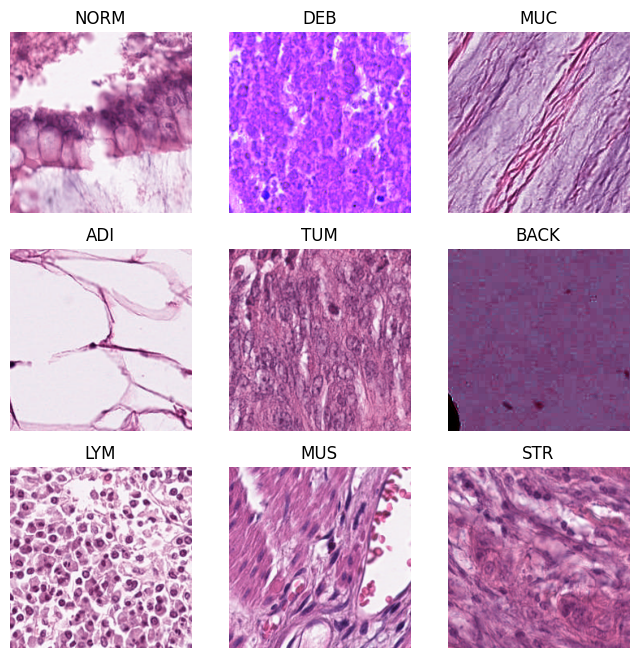

In [22]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(val_set.classes):
            break
    if len(class_examples) == len(val_set.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(val_set.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(val_set.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=1e-6)

In [24]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [25]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)


In [26]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [27]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [30]:
model_path = "HoViT_NCT_batch_32_scheduler_cosineAnnealingWR_50.pth" # Path to the saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
print("Model weights loaded successfully!")

Model weights loaded successfully!


<ipython-input-30-08d9513a0d7f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [31]:
for e in range(num_epochs):
    print(f"\nEpoch {e+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.56it/s]


Train Loss: 0.2619, Train Accuracy: 93.46%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.74it/s]


Validation Loss: 0.1146, Validation Accuracy: 96.92%

Epoch 2/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.09it/s]


Train Loss: 0.0900, Train Accuracy: 97.25%


Validation: 100%|██████████| 32/32 [00:01<00:00, 20.85it/s]


Validation Loss: 0.0689, Validation Accuracy: 97.41%

Epoch 3/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.22it/s]


Train Loss: 0.0575, Train Accuracy: 98.10%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.41it/s]


Validation Loss: 0.0559, Validation Accuracy: 98.21%

Epoch 4/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.03it/s]


Train Loss: 0.0579, Train Accuracy: 98.18%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.82it/s]


Validation Loss: 0.0566, Validation Accuracy: 98.01%

Epoch 5/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.99it/s]


Train Loss: 0.0451, Train Accuracy: 98.57%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.35it/s]


Validation Loss: 0.0422, Validation Accuracy: 98.51%

Epoch 6/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.18it/s]


Train Loss: 0.0409, Train Accuracy: 98.65%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.51it/s]


Validation Loss: 0.0349, Validation Accuracy: 98.71%

Epoch 7/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.87it/s]


Train Loss: 0.0285, Train Accuracy: 99.09%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.65it/s]


Validation Loss: 0.0418, Validation Accuracy: 98.31%

Epoch 8/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.75it/s]


Train Loss: 0.0249, Train Accuracy: 99.17%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.71it/s]


Validation Loss: 0.0299, Validation Accuracy: 99.00%

Epoch 9/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.94it/s]


Train Loss: 0.0184, Train Accuracy: 99.44%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.62it/s]


Validation Loss: 0.0299, Validation Accuracy: 98.61%

Epoch 10/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.89it/s]


Train Loss: 0.0156, Train Accuracy: 99.52%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.03it/s]


Validation Loss: 0.0289, Validation Accuracy: 99.10%

Epoch 11/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.87it/s]


Train Loss: 0.0135, Train Accuracy: 99.57%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.37it/s]


Validation Loss: 0.0235, Validation Accuracy: 99.10%

Epoch 12/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.16it/s]


Train Loss: 0.0142, Train Accuracy: 99.52%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.42it/s]


Validation Loss: 0.0367, Validation Accuracy: 98.61%

Epoch 13/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.68it/s]


Train Loss: 0.0106, Train Accuracy: 99.69%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.98it/s]


Validation Loss: 0.0247, Validation Accuracy: 99.00%

Epoch 14/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.81it/s]


Train Loss: 0.0092, Train Accuracy: 99.75%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.14it/s]


Validation Loss: 0.0171, Validation Accuracy: 99.30%

Epoch 15/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.00it/s]


Train Loss: 0.0088, Train Accuracy: 99.73%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.43it/s]


Validation Loss: 0.0282, Validation Accuracy: 99.00%

Epoch 16/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.96it/s]


Train Loss: 0.0077, Train Accuracy: 99.79%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.86it/s]


Validation Loss: 0.0191, Validation Accuracy: 99.20%

Epoch 17/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.97it/s]


Train Loss: 0.0056, Train Accuracy: 99.88%


Validation: 100%|██████████| 32/32 [00:01<00:00, 21.96it/s]


Validation Loss: 0.0200, Validation Accuracy: 99.30%

Epoch 18/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.24it/s]


Train Loss: 0.0083, Train Accuracy: 99.75%


Validation: 100%|██████████| 32/32 [00:01<00:00, 21.69it/s]


Validation Loss: 0.0208, Validation Accuracy: 99.10%

Epoch 19/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.09it/s]


Train Loss: 0.0052, Train Accuracy: 99.81%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.91it/s]


Validation Loss: 0.0204, Validation Accuracy: 99.20%

Epoch 20/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.06it/s]


Train Loss: 0.0077, Train Accuracy: 99.79%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.49it/s]


Validation Loss: 0.0218, Validation Accuracy: 99.10%

Epoch 21/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.81it/s]


Train Loss: 0.0054, Train Accuracy: 99.77%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.84it/s]


Validation Loss: 0.0159, Validation Accuracy: 99.40%

Epoch 22/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.83it/s]


Train Loss: 0.0058, Train Accuracy: 99.86%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.47it/s]


Validation Loss: 0.0223, Validation Accuracy: 99.00%

Epoch 23/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.71it/s]


Train Loss: 0.0053, Train Accuracy: 99.86%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.46it/s]


Validation Loss: 0.0214, Validation Accuracy: 99.10%

Epoch 24/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.94it/s]


Train Loss: 0.0034, Train Accuracy: 99.88%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.07it/s]


Validation Loss: 0.0208, Validation Accuracy: 99.30%

Epoch 25/30


Training: 100%|██████████| 162/162 [00:10<00:00, 16.16it/s]


Train Loss: 0.0029, Train Accuracy: 99.94%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.64it/s]


Validation Loss: 0.0192, Validation Accuracy: 99.30%

Epoch 26/30


Training: 100%|██████████| 162/162 [00:10<00:00, 16.15it/s]


Train Loss: 0.0038, Train Accuracy: 99.90%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.37it/s]


Validation Loss: 0.0221, Validation Accuracy: 99.30%

Epoch 27/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.84it/s]


Train Loss: 0.0064, Train Accuracy: 99.88%


Validation: 100%|██████████| 32/32 [00:01<00:00, 21.33it/s]


Validation Loss: 0.1438, Validation Accuracy: 95.42%

Epoch 28/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.88it/s]


Train Loss: 0.0077, Train Accuracy: 99.73%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.60it/s]


Validation Loss: 0.0248, Validation Accuracy: 98.91%

Epoch 29/30


Training: 100%|██████████| 162/162 [00:09<00:00, 17.01it/s]


Train Loss: 0.0041, Train Accuracy: 99.88%


Validation: 100%|██████████| 32/32 [00:01<00:00, 23.68it/s]


Validation Loss: 0.0226, Validation Accuracy: 99.10%

Epoch 30/30


Training: 100%|██████████| 162/162 [00:09<00:00, 16.76it/s]


Train Loss: 0.0053, Train Accuracy: 99.86%


Validation: 100%|██████████| 32/32 [00:01<00:00, 22.03it/s]

Validation Loss: 0.0157, Validation Accuracy: 99.60%


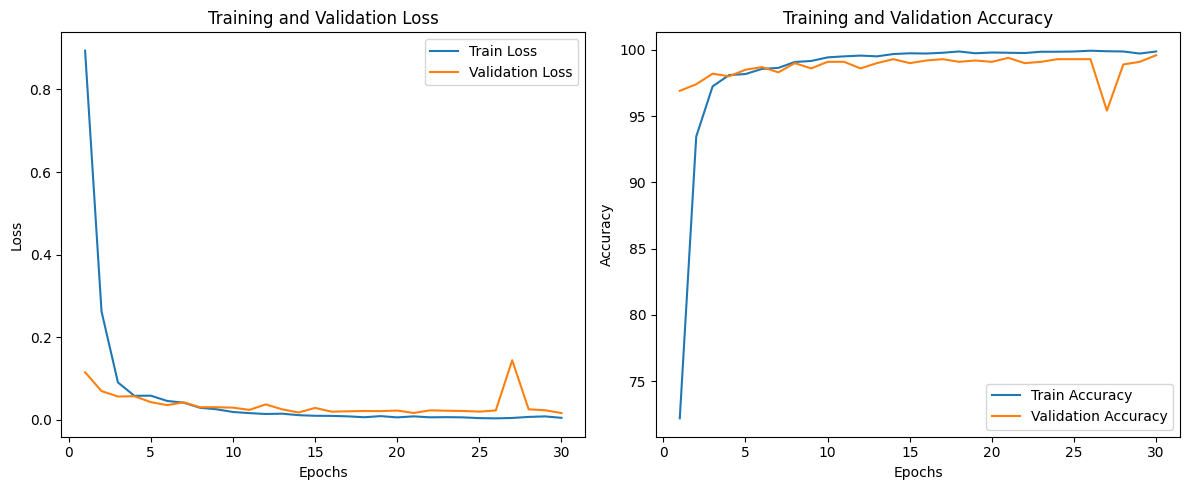

In [34]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[:30], label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies[:30], label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
save_path = "HoViT_NCT_batch_32_scheduler_cosineAnnealingWR_50_7k_finetune_30.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_NCT_batch_32_scheduler_cosineAnnealingWR_50_7k_finetune_30.pth


In [36]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 32
Average Time: 5.89 ms
Standard Deviation: 1.47 ms
Maximum Time: 13.85 ms
Minimum Time: 5.41 ms


In [37]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 32/32 [00:01<00:00, 23.07it/s]


Validation Loss: 0.0278, Validation Accuracy: 99.60%


In [38]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.36%     372.857us        20.97%       3.312ms     137.982us       0.000us         0.00%       2.552ms     106.330us            24  
                                           aten::linear         0.66%     104.824us        15.32%       2.419ms     134.410us       0.000us         0.00%       1.841ms     102.263us            18  
         

In [40]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs2 = model(inputs.flip(2))
            outputs3 = model(inputs.flip(3))
            outputs23 = model(inputs.flip(2).flip(3))
            outputs = outputs.data + outputs2.data + outputs3 + outputs23.data
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels) / 4

            running_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 32/32 [00:02<00:00, 13.73it/s]


Validation Loss: 0.0217, Validation Accuracy: 99.60%
Overall - F1: 0.9954, Recall: 0.9938, Precision: 0.9970
Per-Class Metrics:
Class 0 - F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Class 1 - F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Class 2 - F1: 0.9892, Recall: 0.9787, Precision: 1.0000
Class 3 - F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Class 4 - F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Class 5 - F1: 0.9939, Recall: 0.9880, Precision: 1.0000
Class 6 - F1: 0.9952, Recall: 1.0000, Precision: 0.9904
Class 7 - F1: 0.9915, Recall: 0.9831, Precision: 1.0000
Class 8 - F1: 0.9885, Recall: 0.9942, Precision: 0.9829
Balanced Accuracy: 0.9938


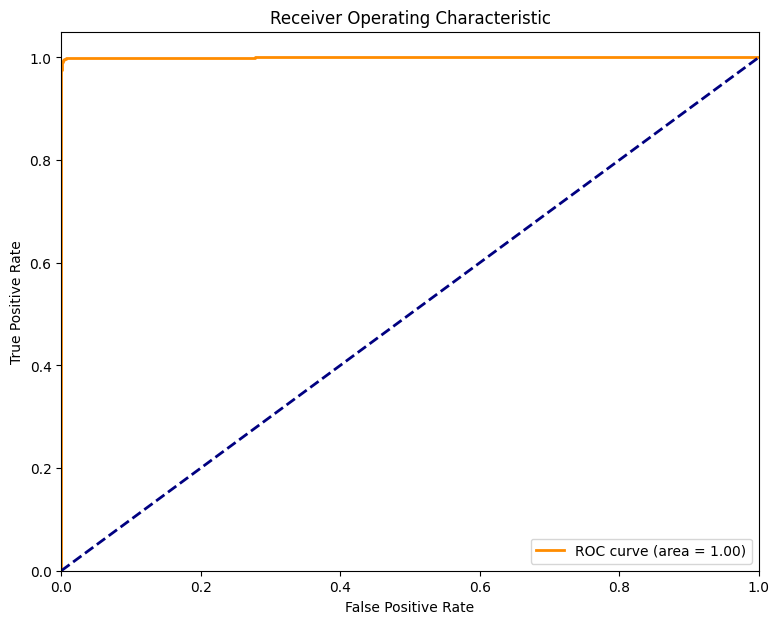

In [41]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

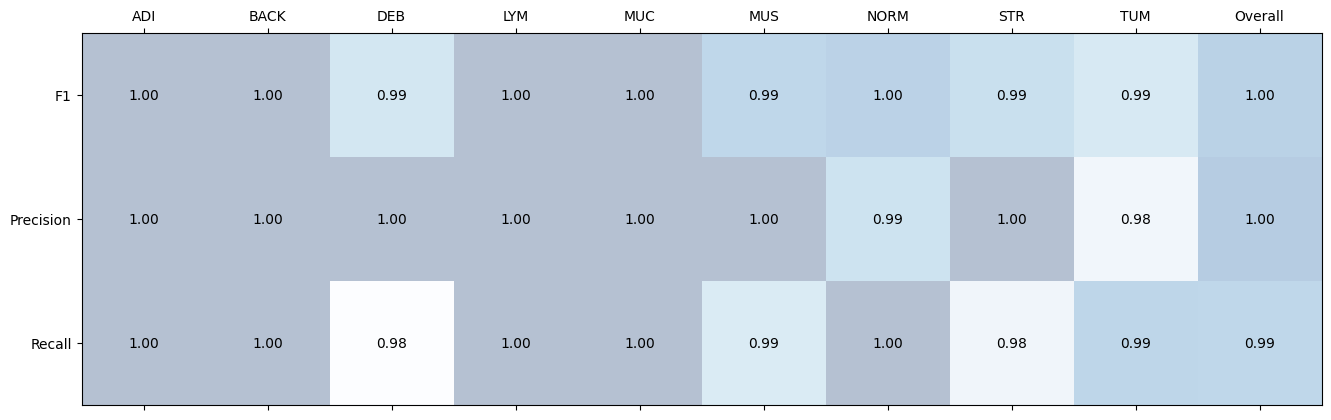

In [42]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )